# 17.어라, 이 시계열 데이터 이상한데? - Anomaly Detection

## 1.들어가며

Anomaly Detection은 산업현장에서 매우 활용도가 높은 데이터처리 기법이다. 예를 한가지 들어보자.

당신은 수백대의 생산설비가 24시간 무중단 운영중인 대규모의 제조시설 운영을 맡고 있는 책임자이다. 그 수백대의 설비는 서로 긴밀하게 맞물려 운영되는데, 자칫 그 중 한 설비에 이상이 생기기라도 하면 공장 전체가 올스톱되어 어마어마한 손실이 발생하게 될 것이다. 문제는, 설비가 고장이 나기 직전까지 겉으로 봐서는 아무런 문제가 드러나지 않기 때문에 도저히 문제 발생을 미리 예측할 수 없다. 할 수 있는 거라곤 멀쩡하게 잘 쓰고 있는 설비도 '그나마 안심하고 쓸 수 있는' 안심내구연한이 지나면 무조건 새것으로 교체하거나, 아니면 설비 센서 앞에 관리자를 24시간 교대근무시키면서 만일의 사태에 빠르게 대응하도록 하는 것뿐일것이다.<br>
이럴때 정확한 Anomaly Detection 모델을 확보할 수 있다면 큰 도움이 될 것이다. 설비에 부탁된 센서의 시계열 데이터를 면밀히 분석해서, 이상발생 얼마 전에 나타나는 이상 징후를 빠르게 포착해서 미리 대비할 수 있게 하면 만일에 발생할 수 있는 천문학적 손실을 예방할 수 있는 요긴한 솔루션이 된다. 그래서 대형 제조업체들은 신뢰할 수 있는 Anomaly Detection 기법을 도입하는데 관심이 매우 많다.

꼭 시계열이 아니더라도 이미지에 대한 Anomaly Detection 분석을 통해 불량품을 찾아내거나 공항/항만에서 반입금지품목을 수색하는 등 정말 다양한 용도의 Anomaly Detection 기법을 생각할 수 있다.

하지만, 오늘 Anomaly Detection을 주어진 데이터를 분석해서 보다 신뢰할 수 있는 데이터로 가공해 가는 전처리 과정의 일부로 접근해 볼까 한다.

머신러닝 분야에는 "Garbage in, Garbage out"이라는 말이 있다. 엉망인 데이터로 모델을 만들면 엉망인 결과가 나온다는 뜻으로, 분석 데이터가 얼마나 중요한지 알려주는 격언이다. 실제로 데이터 분석 업무를 하다 보면 "어라, 이거 이상한데?", "여기서 왜 이런 값이 들어갔지?" 싶은 데이터들이 부지기수로 발견된다. 따로 확인해보면 데이터 전달과정에서 덮어쓰기가 잘못됐거나, 수집 프로그램의 버그인 경우도 심심치 않게 찾아볼 수 있다.

'이상한 데이터=이상치(Anomalies)'는 어떻게 정의할 수 있을까? 또, "Garbage" 소리를 안 들으려면 이상치들은 어떻게 처리해야 할까? 오늘은 시계열 데이터 속에서 **이상치의 의미**를 파악하고, **똑똑하게 찾아내는 방법**을 알아보고 **이상치를 처리하는 방법**까지 연결해볼 것이다. 하지만 이러한 이상치 판별과 처리를 위한 아이디어는 전처리 뿐 아니라 Anomaly Detection의 다양한 용도에 활용할 수 있을 거라 생각한다.

### 학습 목표
---
* 시계열 데이터의 이상치의 개념을 이해한다
* 다양한 방법으로 이상치를 탐색해본다
* 발견한 이상치를 처리하는 방법을 알아본다.

### 목차
---
1. 들어가며
2.  이상한 데이터는 어떻게 생겨났을까요?
3. 신입 데이터 분석가 되어보기 : 시계열 데이터 준비
4. Outlier / Novelties 구분하기
5. 확률분포로 이상치 찾아내기
6. 클러스터링으로 이상치 찾아내기
7. LSTM Auto encoder로 이상치 찾아내기

### Reference
---
* [R Chalapathy, "DEEP LEARNING FOR ANOMALY DETECTION: A SURVEY", 2019](https://arxiv.org/abs/1901.03407)

* [M Braei, "ANOMALY DETECTION IN UNIVARIATE TIME-SERIES: A SURVEY ON THE STATE-OF-THE-ART", 2020](https://arxiv.org/abs/2004.00433)

## 2.이상한 데이터는 어떻게 생겨났을까 ?

<img src="./image/red.png" />
<center>[출처: https://pixabay.com/illustrations/people-special-different-employment-4009327/]</center>

데이터 속에는 유독 혼자서 톡톡 튀는 값들이 있다. 그런 데이터에서 두 가지 방법으로 해석할 수 있다.

1. "세상에는 저런 데이터도 있구나!"
2. "어쩌다가 데이터에 이상한것이 들어왔지?"

모델은 데이터를 통해서 외부환경을 학습한다. 모든 사람의 색깔이 파란색인 데이터만 입력받은 모델은 빨간 사람이나 초록색 사람은 예측할 수 없다. 이때, 입력데이터에 나타난 빨간 사람은 모델이 학습할 외부환경을 추가해서 더 좋은 모델이 되게끔 해준다.

그런데 만약 빨간 사람은 존재하지 않고 단순한 데이터 오류라면, 모델은 빨간 사람 데이터를 학습하지 않는 편이 더 좋을 것이다. 한 번이라도 빨간 사람을 학습하면, 특정 경우에는 사람의 색깔이 빨간색이라고 예측할 수 있고, __그건 늘 틀린 답이기 때문이다.__

우리는 이상한 데이터를 보고 판단해야 한다. __"이 데이터는 어떻게 생성된 건가?"__

<img src="./image/image1.png" />

### 데이터를 무조건적으로 믿으면 안 되는 이유
---
__데이터를 100% 믿는 건 굉장히 위험한 행동이다.__

우리가 다루는 모든 데이터는 생성/측정되고, 수집/전달돼서 컴퓨터로 들어왔다. 이런 데이터 파이프라인 속에서 데이터가 오염될 가능성은 결코 0%가 아니다. 각 단계별로 어떤 위험이 도사리고 있는지 알아보자.

__먼저, 생성/측정 단계__

* 관측자의 실수 (휴먼에러)
* 측정 장비의 오류

기상데이터의 경우, 자동화 측정 장비가 도입되기 전에는 관측관이 직접 수은온도계를 보고 하늘의 상태를 눈으로 봐서 기록했었다. 온도계가 고장 났거나, 노후화됐거나, 관측관의 실수가 있었다면 이상한 데이터가 입력되었을 것이다.

__자동화된 IoT 센서도 문제가 없는 건 아니다.__ 센서는 종종 오작동을 하거나 고장 나기도 한다. 각종 산업 현장에서는 주기적으로 센서 정확도를 점검하지만, 그사이에 발생하면 끔찍한 사고로 연결되기도 한다.

* [보잉 "추락사고 센서 오작동 때문"](https://www.mk.co.kr/news/world/view/2019/04/209953/)

__수집/전달 단계__

* 데이터 수집 프로그램의 오류 (버그)
* 데이터 관리자의 실수 (휴먼에러)
* 데이터 전달 프로그램의 오류 (Open API)

급증한 데이터 생성량에 맞춰서 많은 데이터들이 자동 프로그램으로 수집되고 있다. 생성/측정은 정상적으로 이뤄졌더라도, 수집 프로그램에 버그가 있다면 이상한 데이터가 저장되었을 것이다.

__실무에서 가장 흔한 데이터 오염은 데이터 관리자에 의해 발생한다.__ 데이터 도메인 지식이 없는 IT 담당자의 실수거나, 갑작스러운 부서배치 변경으로 미숙한 담당자가 데이터를 관리하는 등 원인은 다양하다. 하지만, 직접 raw 데이터부터 DB까지 뜯어보며 해결할 수 있는 문제가 아니라면 해결하기도 가장 까다로운 문제이다.

모든 위험을 벗어나도 Open API 설계에 오류가 있다면, 수집한 데이터에는 이상한 값이 들어있을 것이다. (*Open API는 null 값을 0으로 반환하는 버그가 가장 흔하다.*)

### 이상한 데이터를 찾아내는 방법 (Anomaly Detection)
---
하지만 너무 걱정하지 않아도 된다. __데이터 파이프라인 관리자들은 이런 오류를 막기 위해서 온갖 노력을 기울이고 있기 때문이다.__ 그러니 이런 전제를 세울 수 있다.

>"대부분의 데이터는 참이고, 이상한 데이터는 극히 일부일 것이다."

그럼 여기서 한 가지 의문이 생긴다. 어떻게 해야 이상한 데이터를 찾아낼 수 있을까? 다음과 같은 세 가지 방법으로 가능하다.

* 다시 측정한다
* 같은 데이터의 다른 출처를 찾아서 비교한다 (Supervised)
* 데이터 스스로의 특징을 활용해서 찾아낸다 (Unsupervised)

시계열 데이터의 특성상, 과거로 돌아가서 다시 측정하는 방법은 불가능하다.

만약, 같은 데이터를 제공하는 다른 출처가 있다면 Supervised 방법을 쓸 수 있다.

1. 각 데이터를 비교해서 다른 데이터를 찾는다. 서로 같은 데이터는 정상으로 분류한다.
2. 서로 다른 데이터 중에서 '더 이상한' 데이터를 이상치로 분류한다.
3. 라벨링 된 분류 결과로 이상치 탐색 모델을 학습한다.

대부분의 경우에는, 다른 출처가 없어서, Unsupervised 방법을 쓴다. __대부분의 데이터는 참__이라는 전제하에 이상한 데이터를 찾아내는 것이다.

1. 데이터 스스로의 특징을 분석한다.
2. 특정 기준보다 '더 이상한' 데이터를 이상치로 분류한다.

**주가데이터는 네이버, 카카오, 야후 파이낸스 등 다양한 회사에서 제공하고 있다. 만약에 네이버를 통해 수집한 주가데이터가 의심된다면 어느 방법으로 이상한 데이터를 찾아낼 수 있을까?**

* 다른 회사에서 제공하는 같은 데이터와 비교해 보는 Supervised 방법을 사용 가능

**여러분이 기상청에서 기온데이터를 수집했는데, 뭔가 이상한걸 발견했다. 오늘 오후 1시, 2시, 3시의 서울 기온이 24,50,22 라고 나왔다. 어떻게 해야할까?**

* 다른 기상데이터 제공업체를 찾아서, 기상청 데이터와 비교한다. 찾을 수 없다면 기온의 분포에서 크게 벗어난 50도를 이상치로 분류한다.

## 3.신입 데이터 분석가가 되어보자

데이터 분석 업무는 고상할 거라는 세간의 믿음과 달리, 현장에서는 많은 투쟁이 벌어지곤 한다.

### 팀장님, "코스피 데이터는 다뤄본 적 있어요?"
---
여러분) 안녕하세요! 신입사원 김이삭입니다.

팀장님) 응 잘 왔어요. 뛰어난 인재라는 얘기를 많이 들었어요.

팀장님) 방금 기획팀에서 코스피 데이터를 뽑아달라는 요청을 받았는데 몸풀기로 맡겨도 되겠죠? 오픈데이터를 수집해야할 거예요.

여러분) (답은 정해져 있다) 네! 맡겨주세요!

### Time Series 데이터 불러오기 : KOSPI
---
갓 취직한 나에게 주어진 첫 업무이니 잘 해내고 싶다.

왠지 주가데이터는 많은 돈이 걸려있으니 이상치가 없을 거 같다. 진짜 그럴까? 우선 야후 파이낸스를 통해서 코스피 데이터를 수집해보자.

request는 외부 서버에 데이터를 요청할 때 쓰는 라이브러리이다.

```bash
$ pip install requests
```

그리고 아래와 같이 작업환경을 구성해보자.

```bash
$ mkdir -p ~/aiffel/anomaly_detection/kospi
```

In [2]:
import requests
import os

# 아래 url은 yahoo finance 서버에 우리나라 코스피 데이터를 요청하는 주소입니다.
url = "https://query1.finance.yahoo.com/v7/finance/download/%5EKS11?period1=867715200&period2=1597276800&interval=1d&events=history"

# 데이터를 요청하고 그 결과를 response로 받습니다.
response = requests.get(url)

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/kospi.csv'

# response 의 컨텐츠를 csv로 저장합니다.
with open(csv_file, "w") as fp:  
    fp.write(response.text)

우선은 야후에서 받아온 데이터를 'kospi.csv'로 저장했다.

> __(주의) 하지만 방금 다운받은 kospi.csv 대신 아래 링크의 데이터셋을 대신 사용해야한다!__<br>
_Yahoo finance에서 제공하는 데이터에 포함된 이상데이터(극단치와 특이치)를 추적하는 과정을 다루고 있다.<br>
하지만 2021년 1월 현재, Yahoo finance의 데이터 내의 오류가 수정되어 아래에서 제시하는 학습내용이 재현되지 않는 문제가 있다. 그래서, 원활한 실습을 위해 이상데이터가 포함된 구버전 데이터셋을 사용해야한다._

**[kospi.csv](https://d3s0tskafalll9.cloudfront.net/media/documents/kospi.csv)**

```bash
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/kospi.csv
$ mv kospi.csv ~/aiffel/anomaly_detection/kospi
```

Pandas 라이브러리에서 제공하는 DataFrame 타입으로 데이터를 불러와서 값을 확인해보자.

In [4]:
# 저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,0.0
1,1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,0.0


불러온 데이터셋은 일반적인 다변량 시계열 데이터의 형태를 띠고 있다. 딱 봐도 주가데이터임을 알 수 있는 Open/High/Low/Close/Volumn 등 컬럼명이 보인다.

'Date' 는 시간데이터지만, CSV를 통해 불러와서 data type이 string일 것이다. 이걸 Datetime 으로 캐스팅하고 결측치 유무를 확인한다.

**주식 데이터에서 Open, High, Low, Close, Adj Close, Volume 은 각각 무슨 의미일까?**

* 시가, 고가, 저가, 종가, 보정종가, 거래량

In [5]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date           0
Open         150
High         150
Low          150
Close        150
Adj Close    150
Volume       150
dtype: int64

어이쿠 결측치가 있는 날짜가 150개나 되는 모습이다. 이대로 내버려 두면 모델에서 예상치 못한 오류가 발생할 수 있다.

이렇게 분석 시계열 데이터에 결측치가 있다면 어떻게 해야 할까? 결측치 주변의 데이터를 이용해서 보간(interpolation)하거나, 삭제하는 방법을 생각해 볼 수 있을 것이다. 하지만 결측치를 다루는 방법을 이미 공부한 적이 있다.

이번에는 Pandas의 dropna 함수를 사용해서 Nan 값의 결측치를 삭제해볼것이다.
만약 dropna 가 잘 기억나지 않는다면 [링크](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)를 참고.

In [6]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 5842
삭제 후 데이터 길이(일자수): 5692


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

성공적으로 Nan 값이 제거되었다.

그런데 왠지 꺼림칙한 기분이 든다. __"데이터를 무조건적으로 믿지 말라"__ 는 얘기가 떠오른다.

혹시나 하는 생각에 정리된 주식데이터를 그래프로 그려 확인해보자.

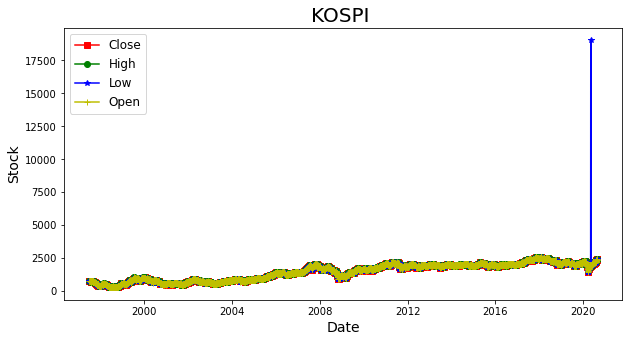

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

저건 뭐다냐?ㅎㅎ

2020년 이후에 파란색 Low 가격에 이상한 값이 삐죽 솟아있는 부분이 눈에 띄인다.
이렇게 비정상적으로 데이터 그래프가 솟아오른 부분을 스파이크(spike)라고 하고, 움푹 꺼진 부분을 딥(dip)이라고 한다.

이상한 스파이크는 2020년 이후에 발생했고, Low Price 값이 High Price 값보다 훨씬 높게 삐죽 솟아 나와 있으니 확실히 이상한 데이터다.

구체적인 수치를 확인하기 위해 pandas DataFrame에서 확인해보자.

In [8]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume
5620,2020-05-06,1919.449951,1928.76001,19025.550781,1928.76001,1928.76001,1082200.0


범인은 2020년 5월 6일이었다. Low Price가 19025로 나타나있다.

이제 시계열 데이터의 이상치 데이터가 무엇인지 감을 잡을 수 있을 것이다.

이번에는 다행히 그래프를 통해 눈으로 여러분의 첫 번째 이상치 데이터를 찾을 수 있었다. 하지만, 이런 생각이 스쳐 간다.

>"이 이상치 데이터는 어떻게 처리하지?"

다음 단계에서는 이상치 데이터의 종류와 처리방안을 알아보자.

## 4.Outlier / Novelties 구분하기

현재 갖고 있는 주식데이터에 관한 도메인 지식에 따르면, 저가는 무조건 다른 가격들보다 낮은 가격이어야 한다. 이런 규칙에 맞지 않았기 때문에 2020년 5월 6일의 이상한 데이터를 찾아낼 수 있었다.

이렇게 이상한 데이터, 즉 이상치(Anomalies)를 찾아내는 방법이 Anomaly Detection이다. 일반적으로는 이상치를 정상적인 데이터들의 분포에서 벗어난 데이터라고 정의하지만, 세부방식에 따라 크게 Outlier와 Novelties 두 가지로 구분할 수 있다.

### 첫 번째, outlier (극단치)
---
Outlier의 사전적 정의는 다음과 같다.

>_통계적 자료 분석의 결과를 왜곡시키거나, 자료 분석의 적절성을 위협하는 변숫값 또는 사례_

Outlier는 일반적으로 단변량 분석의 결과로 찾아낼 수 있으며, __교정하지 않으면 자료 분석에 방해가 된다는 특징이 있다.__

__(대응 방안)__<br>
특히, 비정상적인 데이터 수집 과정에 의한 극단치는 원본 데이터를 교정하여 없애는 걸 권장한다.

* 참값으로 대체하거나
* 보간으로 대체하거나
* 삭제해야 한다.

다행히 주식데이터는 네이버, 카카오 등 다양한 IT 업체에서도 제공하는 데이터이다. Supervised 방법을 통해서 데이터를 검증할 수 있다.

<img src="./image/kospi.png" />

카카오 주식차트로 확인해보면 Low는 1903이 맞는 값이다.<br>
반올림을 고려하면 야후에는 소수점 한 칸이 밀려서 입력되는 거 같다.<br>
앞서서 발견된 이상치(2020년 5월 6일 Low 값)은 비정상적인 수집 결과이므로 해당 데이터를 교정하여 없애보자.<br>

In [9]:
# 카카오 주식차트 결과로 대체합니다. 
df.loc[df.Date == '2020-05-06', 'Low'] = 1903 

# 비정상데이터가 제거되었는지 다시 확인해 봅니다.
df.loc[df.Low>df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


굿! 잘 제거된 모습이다.

### 두 번째는, Novelties 특이치
---
Novelties는 정상적인 수집과정에 의한 이상치를 의미한다. 이전까지는 보지 못한 패턴이나 데이터가 여기에 해당된다. 마치 블랙스완처럼! 특이치는 모르는 도메인의 변화를 시사한다. 특이치는 일반적으로 다변량 분석의 결과로 탐색할 수 있다.

__(대응 방안)__<br>
특이치는 극단치와 다르게 원본 데이터를 수정하지 않는다.<br>
나중에 특이치가 또 발생하면 모델이 대처해야 하기 떄문이다!

코스피 데이터에서는 코로나 사태로 인한 주식하락 같은 날벼락도 일종의 특이치Novelties로 볼 수 있다.

<img src="./image/Novelty_Anomalies.png" />
<center>[Novelty와 Anomalies의 개념적 차이]</center>

위 그림은 '들어가며'에서 소개했던 참고문헌 [Deep Learning for Anomaly Detection: A Survey](https://arxiv.org/abs/1901.03407)에서 Novelty와 Anomalies의 개념적 차이를 설명하기 위해 제공된 것이다.<br>
정상적인 범주에서 벗어나는 이상 데이터라고 해도 엄밀히는 같은 것이 아니라는 것을 알 수 있을 것이다.

위 그림을 예로 들자면, 만약 우리가 `호랑이`라는 데이터를 조사한다고 했을 때, `하얀 호랑이`라는 것이 아무리 처음 관측되었다고 해도 그것이 `호랑이`의 범주에 든다면 그것은 특이치(Novelty)로 취급되어 호랑이 데이터 안에 포함되어야 한다. 그러나 호랑이 데이터 안에 실수로 사자나 표범 같은 호랑이 범주 밖의 데이터가 끼어들었다면 그것은 극단치(Outlier)로 간주해서 호랑이 데이터에서 제외해야 하는 것이다.

위 그림에서는 Normal의 범주 밖에 있는 것을 Outlier라고 하지 않고 Anomalies로 표기하는 모습을 볼 수 있다. 위 논문에서는 Anomaly와 Outlier를 같은 뜻으로 혼용하고 있음에 유의해야한다.

### Recap!!
---
(세줄 요약)

* 이상치(Anomailies) = 극단치(Outlier) + 특이치(Novelites)
* 극단치는 제거해야 모형에 좋다.
* 특이치는 남겨둬야 모형에 좋다.

### 모든 데이터에서 똑같은 방법으로 극단치와 특이치로 구분하나요?
---
극단치와 특이치에는 사실 뉘앙스의 차이가 있을 뿐 명확한 구분 방법은 없다. 분석자의 주관이나 데이터의 도메인(분야)에 따라 조금씩 다르다. 결국 그 데이터 범주의 경계선을 어디에 그었느냐의 문제가 귀결될 것이기 때문에, 해당 도메인의 지식이 중요하게 취급된다.

지금 다뤘던 주식데이터에서도 만약 Open/Low/Close/High 등 데이터의 의미를 모르고 분석했다면 2020-05-06일 이상치를 찾아낼 수 있었을까??

Outlier 와 Novelties 에 대한 더 자세한 한글 설명은 [여기](https://hoya012.github.io/blog/anomaly-detection-overview-1/) 참조

## 5. 전통적인 방법으로 이상데이터를 찾아보자!
다른 출처에서 제공하는 데이터가 있다면 상호 비교하는 Supervised 방법으로 하나의 이상치를 제거할 수 있을 것이다. 하지만, 야후 파이낸스와 달리 네이버/카카오는 코스피 데이터의 다운로드 기능을 제공하지 않았다.<br>
눈으로 하나하나 확인해볼 수도 없는 노릇! 숨어있을 다른 이상치들은 어떻게 처리하나 고민~고민하다가 예전 중고등학교 시절 배웠던 **정규분포**의 개념이 떠올랐다.

어떤 데이터가 평균과 표준편차로 주어지는 정규분포를 따른다면 아주 높은 확률로 그 데이터는 어떤 **신뢰구간** 내에 있을 거라고 가정할 수 있으며, 그 신뢰구간 밖의 데이터가 나올 확률은 매우 희박해진다면 **신뢰구간 밖에 있는 데이터는 이상치**라고 생각할 수 있지 않을까?

이번 스텝에서는 통계적 기법을 많이 사용하게 되므로, 아래 라이브러리를 설치하자.

```bash
$ pip install statsmodels
```

### 기억 더듬어보기 : 신뢰구간

---

중고등학교 시절 배웠던 '정규분포'와 '신뢰구간' 의 개념을 잠깐 되짚어보자.

*이번에 우리는 데이터가 '정규분포'를 따를 때 사용 가능한 신뢰구간으로 이상치를 탐색할 것이다.*

데이터가 정규분포를 따를 때, 표준편차($\sigma$)의 배수로 신뢰구간의 상한과 하한을 결정한다. 신뢰구간을 벗어나는 데이터는 일반적인 분포에서 벗어나는 '이상치'로 의심할 수 있다.

* ($2\sigma$를 기준으로 판단하면) 95.5%는 정상데이터, 4.5%는 이상치,
* ($3\sigma$를 기준으로 판단하면) 99.7%는 정상데이터, 0.27%는 이상치로 분류할 수 있다

**(여기서 잠깐)** 신뢰구간 분석을 통해 이상치를 찾아내는 방법은 데이터가 정규분포를 따를 때만 쓸 수 있는 것은 아니다. 데이터가 t-분포 등 특정 확률분포에 피팅이 된다면 그 확률분포의 신뢰구간 결정 방법을 적용할 수 있다.

이상치를 찾아내는 통계적인 방법은 정말 다양하지만, 우리는 아래 두 가지 대표적인 방법을 알아보겠다.

* 정규분포를 따르는지 확인하는 방법 : **z-test**
* 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법 : **Time series decomposition**

### z-test : 우리 데이터는 정규분포일까?
---
우리가 가진 코스피 데이터의 분포를 그래프로 확인해보자.

정규분포는 다음과 같이 그릴 수 있다.

In [ ]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.001)
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

우리 데이터도 이런 분포를 가진다면 참 좋을 것이다.

그럼 우리 주식 데이터의 분포를 확인해보자. 대표적으로 주식의 '종가 Close'를 그려보자

한눈에 봐도 딱 정규분포와는 거리가 먼 분포이다... 가운데가 전혀 볼록하지 않다. 하지만 직관이 아닌 숫자로 판단해보자.

단변수의 정규분포 여부는 z-test 방법으로 확인할 수 있다. z-test 방법은 고등학교 통계 과정에서 다루고 있는 내용이긴 하지만 오랫만이라 생소할  수 있으니 아래 링크의 친절한 설명을 참고하자.

(참고)[Z-test, T-test](https://blog.naver.com/oooasd73/221610919338)

In [ ]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

* p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다는 뜻이다.
* 즉, 이런 데이터로는 '정규분포'를 가정한 통계적 추정이 어렵다.
* 그렇다면 이 데이터에 대해서는 정규분포를 가정한 신뢰구간 분석은 적용하기 어려울 것이다.

### 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법 : Time series decomposition

---

**시계열 데이터의 3가지 성분**

시계열 데이터의 예측 모델을 논할때 Stationary 개념은 절대 빠질 수 없다. Stationary의 개념에 대해서는 아래 링크를 참고. 시계열 예측을 다룬다면 명확히 알아야 하는 개념이지만, 지금으로선 평균, 분산, 공분산이 일정한 Stationary 시계열에 대해서만 미래 예측이 가능하다는 기본 개념을 알아두자.

(참고)[A Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

하지만 우리가 다룰 대부분의 시계열 데이터는 Stationary하지 않고 계속 변화하는 패턴을 보인다. 이때, 시계열을 Stationary한 컴포넌트와 Non-stationary한 컴포넌트로 나누어 분석하기 위해 주로 사용하는 기법이 Time series decomposition이다. Time series decomposition을 통해 시계열 데이터는 3가지 성분으로 분리되고, 그중 **Residual 성분의 데이터가 Stationary에 가까운 형태**를 가진다.

이때 **Stationary에 가까운 데이터는 정규분포를 따른다**. 우리는 이 Residual 데이터를 사용해서 신뢰구간을 구할 수 있다. Time series decomposition에 대한 좀더 구체적인 설명은 아래 링크를 참고.

(참고)[Time series decomposition](https://rfriend.tistory.com/510)

**statsmodel 에서 제공하는 Time series decomposition 은 시계열 데이터를 3가지 패턴으로 분류한다.**

* trend, seasonal, residual (또는 resid)

**Time series decomposition된 패턴 중에서 어떤 것이 stationary에 가까울까?**

* residual (또는 resid)

Time series decomposition은 'additive' 방법과 'multiplicative' 방법이 있다. 본 예제에서는 additive 방법을 적용해보겠다.

Statsmodel 라이브러리를 이용해서 코스피 종가 데이터를 분석해보자.

계절적 성분의 주기는 임의로 50일로 가정하겠다.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

In [ ]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

In [ ]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()
#-8 에서 10 사이를 주기적으로 반복하는게 보이네요.

### 우리는 Time series decompose 결과에서 무엇을 알 수 있나요?
---
* 우리는 정규분포에서 표준편차를 이용한 이상치 인식을 사용하고 싶다.
* 추세Trend 와 계절적 성분Seasonal을 뽑아내고 남은 잔차Residual를 보자.
* 잔차는 평균 0을 기준으로 분포하고 있다.
* 잔차가 큰 날은 뭔가 일반적인 추세나 계절성에서 벗어난 날로 해석될 것이다.
* 그럼 Residual의 분포를 그려보도록 하겠다

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

어떤가? 이런 모양새면 정규분포로 가정해도 될 거 같다. 다시 한번 z-test를 통해 숫자로 확인해보자.

In [ ]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

p-value가 0.05 이상으로 아주 강하게 나타난다. 데이터 분포가 정규분포를 잘 따르고 있다는 뜻이다.<br>
이러면 정규분포로 가정하고 분석해도 될 것 같다.

**time series decompose 에서 two_sided=True 의 의미는 무엇인가?**

* Trend 성분을 만들기 위해 freq 길이에 해당하는 샘플이 필요합니다. 이걸 rolling window로 만들어낸다. 우리의 예제에서는 period=50 이기 때문에 two_sided=True라면 049번째 데이터로 25번째 Trend값을, 150번째 데이터로 26번째 Trend값을 생성한다. two_sided=False라면 049번째 데이터로 50번째 Trend값을, 150번째 데이터로 51번째 Trend값을 생성한다.

**time series decompose 에서 extrapolate_trend='freq'의 의미는 무엇인가? 빼면 무슨 일이 생기나?**

* 위의 Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend, resid에는 Nan 값이 발생한다. 우리의 예제에서는 period=50 이기 때문에 two_sided=True라면 맨앞에서 25개, 맨뒤에서 25개가 Nan이고, two_sided=False라면 맨앞에서 50개가 Nan이다. 이렇게 발생하는 Nan 값을 채워주는 옵션이 extraplate_trend 입니다 이 옵션을 빼면 Trend와 Resid에 Nan 값들이 생긴다.

**Time series decompose 에서 additive 는 Observedt = trendt + seasonalt + residt 였다. 만약, multiplicative 로 분석하면 어떤 결과가 나오는가?**

* Observedt = trendt x seasonalt x residt 위 식의 양변에 로그를 취하면 결과적으로 additive와 동일한 결과가 얻어진다.

### $3\sigma$ 기준 신뢰구간으로 이상치 찾기
---
신뢰구간 방법으로 이상치를 탐색하려고 한다. 평균을 기준으로 플러스/마이너스 $3\sigma$를 벗어나는 데이터를 찾아보자.

In [ ]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

5692개의 데이터 샘플 중에서 71개의 이상치를 찾아냈다.

어떤 날들인지 확인해보자.

In [ ]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

### 신뢰구간 방법의 한계점은 뭘까?
---
2008년 금융위기 때와 2020년 코로나 위기가 있던 시기가 많이 잡혔다. 경제 위기가 닥치면 장기적인 패턴에서 벗어나게 되니, 일반적인 경제 상식에 비춰봤을 때 합리적인 결과로 생각된다. 아마 신뢰구간으로 걸러진 71개의 이상치 후보군은 대부분 특이치(Novelty)라는 생각이 든다.

그래도 Supervised로 5682개를 하나하나 확인하기는 어려웠는데, 71개로 줄었으니 이제는 비교해도 좋을 거 같다.

사실 신뢰구간 방법에서는 종가 Close 하나의 지표만 활용해서 이상치를 찾아냈다. 다른 지표별로 분석해보면 71개가 아니라 몇백 개를 찾아봐야 할 수도 있다.

**다양한 데이터로 더 그럴싸한 Anomalies를 찾아낸 다음, 노가다를 최소한으로 하는** 그 방법을 **Multi-variable Anomaly Detection**이라고 부른ㄷ나. 일반적으로는 두 가지 알고리즘을 사용한다.

* Clustering : 클러스터링으로 묶으면 정상인 데이터끼리 이상한 애들끼리 그룹핑되니 이상한 그룹을 찾는다.
* Forecasting : 시계열 예측모델을 만들어서, 예측 오차가 크게 발생하는 지점은 이상한 상황이다. 일반적으로 Auto-Encoder로 탐색한다.

다음 단계에서는 클러스터링으로 다변량 이상치 탐색을 하는 방법을 다뤄볼 것이다.

## 6. 클러스터링으로 이상치 찾기 : K-means와 DBSCAN

### 데이터 전처리
---
이번에는 Open, High, Low, Close, Volume 5가지 데이터를 모두 사용할 것이다.

앞서 살펴본 통계방식과 동일하게 Trend/Seasonal 성분을 제거해야 '정말 튀는' 데이터를 찾아낼 수 있다. 같은 방법으로 **5가지 데이터 모두** time series decompose로 전처리를 해줄 것이다.

In [ ]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

In [ ]:
rdf.describe()

각 변수마다의 잔차(residual)을 살펴보면 Volume 혼자서 너무 숫자가 크다는 걸 알 수 있다.

이런 데이터를 그대로 분석에 사용하면 Volume이 가장 중요하게 반영될 것이다.

한쪽에 쏠리는 걸 제외하기 위해 각 변수들을 표준정규화 해준다.

In [ ]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

#### K-means 와 DBSCAN

* k-means 와 DBSCAN 은 대표적인 unsupervised clustering 알고리즘이다.
* 입력된 데이터들을 유사한 몇개의 그룹으로 분류해준다.
* k-means 은 몇 개의 그룹으로 묶는지 미리 지정해 주는 반면, DBSCAN은 지정해 줄 필요가 없다.

### k-means 로 이상치 탐색하기
---
우리는 k-means을 이용해서 정상 데이터그룹과 이상치 데이터그룹을 나눠볼 것이다.

이때, 그룹은 2개로 지정하면 되겠죠? 한번 코드로 확인해보겠다.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

In [ ]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

분석 결과 0번그룹은 3283개의 샘플, 1번그룹은 2409개의 샘플로 분류됐다.

어느 한쪽을 이상치 그룹이라고 선택하기에는 너무 많이 분류됐다.

그룹 숫자를 더 늘려서 분석해보겠다.

**k-means의 'random_state=0'의 뜻은 무엇일까?**

* k-means는 난수를 이용하기 때문에 실행할 때마다 결과가 다를수 있다. 그래서 동일한 분석결과를 얻기 위해서는 난수설정값을 통일시켜주는 과정이 필요하다. np.random.seed() 와 비슷한 역할을 하는 코드이다.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

특이그룹 번호는 수행 결과에 따라 다를 수 있다. 그러나 이렇게 특이하게 분류된 그룹에 속한 데이터의 경우 유사한 날들이 거의 없다는 뜻이므로 우리가 찾고 있는 이상치로 볼 수 있다.

다음 활동을 통해 이상치를 분석해 보겠다.

1. 어떤 날들이 분류된 건지
2. 각 그룹은 어떤 특징을 갖고 있는지
3. 왜 이상치로 분류된 걸까?

#### 1. 어떤 날들이 분류된 건지 (원본 코스피 데이터에서 탐색)

In [ ]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==3)|(kmeans.labels_==9)|(kmeans.labels_==10)]

In [ ]:
df.describe()

In [ ]:
# 2004-04-14 주변 정황
df.iloc[1660:1670]

#### 2. 각 그룹은 어떤 특징을 갖고 있는지

In [ ]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

* 다른 그룹들은 거래량 값이 매우 작지만, 2개 그룹의 거래량 수치가 유독 크다.
* 그리고 Open, High, Low, Close의 값이 유독 낮은 그룹이 하나 있다. 

#### 3. 왜 이상치로 분류된 걸까?

* **3번 10번 그룹의 거래량은 비정상적이다.**

df.describe()로 알아본 전체 평균 거래량은 4,329,776이다.

그런데 3번 10번 그룹은 거래량이 250,000,000 이상으로 평균 대비 60배 이상 많다.

한번 인터넷 검색으로 이 값들이 맞는지 확인해보자

(적합한 사이트를 찾기 어렵다면 [링크](https://kr.investing.com/indices/kospi-historical-data)를 활용)

확인 결과 우린 다시 한번 야후 파이낸스의 실수를 찾아냈다.

3번 10번 그룹의 거래량은 나누기 1000을 해야 정상적인 값이 된다.

* **9번 그룹은 각 그룹의 특징에서 답을 찾을 수 있었다.**

슬프게도 코스피 역사상 가장 큰 폭락장이었던 날이다.

In [ ]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True, color='b')
tdf.Close.plot(ax=ax, label='Trend', legend=True, color='r')
rdf.Close.plot(ax=ax,label='Resid', legend=True, color='y')
plt.show()

파란색은 실제 코스피지수고, 빨간색은 트렌드, 그리고 잔차가 노란색이다.

COVID19 때문에 2020년 3월에 발생한 폭락장으로 인해 아래로 깊게 파인 잔차가 보인다.

기대했던 추세보다 너무 많이 하락한 것이다.

즉, 우리가 예상하지 못한 이상치가 맞다.

### Recap
---
우리는 Unsupervised Learning 중에서 K-means 알고리즘을 이용해서 Anomaly Detection을 해보았다.

1. 소수 그룹이 형성될 만큼 충분한 그룹수로 클러스터링한다
2. 소수 그룹의 특징을 분석한다
3. 해당 소수 그룹들이 이상치인지 추론해본다.

### DBSCAN 으로 이상치 찾기

---

이번에 우리는 DBSCAN 을 이용해서 데이터를 클러스터링하고, 이상치 그룹을 찾아낼것이다. K-means과 달리, DBSCAN 알고리즘은 클러스터의 개수를 지정할 필요가 없다. 아주 간단히 말해서, DBSCAN 알고리즘은 핵심벡터와 일정 거리 $\epsilon$ 이내인 데이터 벡터들이 군집(Cluster)을 이루게 하는데, 그러한 군집들과 거리상 동떨어져 군집에 들지 못하는 특이한 데이터들을 노이즈(Noise) 벡터라고 부른다. DBSCAN을 통해 이상치를 찾는 것은 바로 이러한 노이즈 벡터를 찾는 것과 같다.

DBSCAN에 대해 좀 더 자세한 안내가 필요하다면 아래 자료를 참고.

- [DBSCAN 알고리즘](https://gentlej90.tistory.com/29)

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

In [ ]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

In [ ]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

DBSCAN은 41개, 3개, 2개의 소수 그룹을 분류해냈다.

## 7. Auto-Encoder를 이용한 이상치 탐색

드디어 여기까지 왔다.

앞서 살펴본 예제들의 기본 로직은 동일하다.

1. Time series decomposition 을 이용해 Trend/Seasonal/Residual 값으로 분리한다
2. Residual 값의 분포를 이용해서 이상치를 탐지해낸다

**통계적 방법과 Unsupervised Clustering 기법의 장점**

1. 적은 샘플 수로도 분석이 가능하다 (샘플 수가 50개 이상이면 적용 가능)
2. 하드웨어 제약이 거의 없다

**통계적 방법과 Unsupervised Clustering 기법의 단점**

1. Time series decomposition에 의존해야 한다는 점
2. 분석자의 주관이 필요하다는 단점이 있었다.<br>
(통계기법:몇 배수의 표준편차?, k-means:몇 개 그룹으로 클러스터링?, Time Series decompose: freq는 몇으로?)

우리는 대 딥러닝의 시대를 살고 있으니 이상치 탐색에도 딥러닝 모델을 적용해보자.

딥러닝을 적용하면 다음 부분에서 장단점이 있다.

**딥러닝 이상치 탐색의 장점**

1. Time series decompostion 없이 분석 수행이 가능하다
2. Trend, Seasonal 데이터를 포함하고 있기 때문에 Trend, Seasonal의 변화도 이상치로써 탐색이 가능하다.

**딥러닝 이상치 탐색의 단점**

1. 분석자의 주관이 어느 정도 필요하긴 하다 (Threshold, window)
2. 학습에 활용할 만큼 충분한 데이터가 확보되어야 한다.

* 본 예제는 [keras 공식 예제](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)를 재가공 했다.

### Auto encoder란?
---
* 오토인코더는 인코더와 디코더로 구성된다.
* 인코더는 입력데이터로부터 중요한 정보(Compressed Feature Vector)를 뽑아낸다
* 이 과정에서 입력데이터보다 압축된 형태의 데이터를 얻는다.
* 디코더는 중요한 정보로 입력데이터와 유사한 형태를 재생성(Generate)한다.

인코더가 중요한 정보를 '잘'뽑아내면, 디코더는 입력데이터를 거의 똑같이 생성해낼 수 있을 것이다.

비정상적인 데이터들은 디코더가 똑같이 생성하기 어려울 것이다.

우리가 오토인코더를 Anomaly Detection에 사용하는 이유이다.

In [ ]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

### LSTM 을 이용한 오토인코더 모델 만들기
---

#### 데이터 전처리

* 입력 변수를 정규화시켜줘야 딥러닝 모델 학습이 원활하다
* 가장 일반적인 표준정규분포로 전처리한다

In [ ]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

### keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

* data : 입력데이터(x)를 넣어준다. 우리는 'Open','High','Low','Close','Volume' 5가지 인풋을 사용한다.
* targets : 출력데이터를 넣어준다. 우리는 5가지 인풋 그대로 예측하기 때문에 data와 동일한 걸 넣어즌다.
* length : 몇 개의 time_step을 참고할지 입력한다.
* stride : time_step 사이즈를 결정한다.

* 더 자세히 알고 싶다면 [텐서플로우 공식 문서](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator)를!

In [ ]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

#### 모델 만들기

* 2개 층의 LSTM으로 인코더를 만든다
* RepeatVector는 input을 window_size 만큼 복사해준다.

In [ ]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

In [ ]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [ ]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

In [ ]:
model.load_weights(checkpoint_path)

#### 학습 과정을 확인해보겠습니다.
* 안정적으로 Training loss 가 수렴하고
* Validation loss 가 발산하지 않음을 확인

잘 학습되는거 같다!

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

#### 분석 시 주의할 점!!
우리는 시계열 데이터를 window_size 만큼 밀어가면서 예측하는 모델을 만들었다.

그래서 train_gen의 길이는 원본 df의 길이보다 window_size 만큼 짧다.

예측 결과와 비교할 때는 scaled의 앞에서 window_size 만큼을 건너뛰어야한다.

In [ ]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

### 어라? mae_loss가 3 이상으로 동떨어진 샘플이 몇 개 보이네요?
---
아무래도 우리가 찾는 이상치 같다. 좀더 자세히 확인해보겠다.

mae_loss의 기준치를 3으로 해서 분석한다.

scaled 데이터는 스케일링 조정되어있기 때문에 원본 데이터인 df로 비교해야 한다.

기존의 df와 mae_loss 까지 합쳐서 분석하기 위한 데이터프레임을 새로 하나 만든다

In [ ]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

우리가 Clustering 에서 찾았던 Volume 이상치 4개를 똑같이 찾았다!

이상치 탐지가 정상적으로 동작하는 거 같다!!

기준치를 더 낮춰서 보다 많은 이상치를 찾아보겠다

In [ ]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

#### 그래프로 그려서 이상치를 찾아봐요

* Open, Close, Low , High 같은 데이터는 스케일이 비슷하니 한 번에 그려도 좋을 것이다
* 하지만 Volume과 loss는 스케일이 다르니 각각 그래프를 그려보자
* 기준치로 분류해낸 이상치들은 붉은 점으로 그려서 나타낸다


In [ ]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

그래프에 붉게 표시된 이상치들이 한눈에 보인다.

이렇게 코스피 데이터에 있는 이상치들을 찾아봤다.